## **Install and import libraries**

**Install Python libraries**

In [1]:
!pip install sklearn
!pip install pyyaml==5.4.1
!pip install contractions
!pip3 install catboost
!pip install imblearn

In [2]:
conda install -c conda-forge wordcloud=1.8.1

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


**Import Python libraries**

In [93]:
# Exploratory Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import plotly.figure_factory as ff

# Text Pre-processing
import contractions
import re
import string
import nltk
nltk.download('punkt')
nltk.download('brown')
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import brown
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# # Data processing libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import LabelEncoder

# Hyperparameter tuning with grid search with cross validation
from sklearn.model_selection import GridSearchCV

# Machine Learning Algorithms
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

# Model Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve

[nltk_data] Downloading package punkt to /Users/golf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /Users/golf/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/golf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/golf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Nice display
from IPython.display import HTML
def pretty_print_df(value_counts_):
  display(HTML(pd.DataFrame(value_counts_).to_html()))

import warnings
warnings.filterwarnings('ignore')

## **Load the dataset (Amazon Reviews)**

In [5]:
# Load the dataset (Amazon Reviews)
dataset = pd.read_csv('.../Task 4 - “Amazon reviews” dataset/processed_reviews_split_surnamesR_minimal.csv')
dataset.head(10)

,review_id,text,verified,review_score,product_category
0,product_review_000000,I am one of those people who had Gran Turismo ...,False,1.0,video_games
1,product_review_000001,This game is awful for several reasons.\n1. T...,False,1.0,video_games
2,product_review_000002,This case is great for travel with the 3Ds or ...,False,5.0,video_games
3,product_review_000003,My go-to mic cable for quite a few years now. ...,True,5.0,musical_instruments
4,product_review_000004,The left one falls fairly frequently even when...,True,4.0,video_games
5,product_review_000005,I've played a lot of strings. These are what ...,True,5.0,musical_instruments
6,product_review_000006,Love these things.. Love Amazon,True,5.0,video_games
7,product_review_000007,This is a standard piece of equipment that mos...,True,-1.0,musical_instruments
8,product_review_000008,The D'Addario half-round jazz light strings su...,True,-1.0,musical_instruments
9,product_review_000009,"The reviews were so negative, I was scared to ...",True,5.0,video_games


## **Data quality assessment and Exploratory Data Analysis**
Explore the data to find out any issues

In [6]:
# Dataset information
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32917 entries, 0 to 32916
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         32917 non-null  object 
 1   text              32908 non-null  object 
 2   verified          32811 non-null  object 
 3   review_score      32917 non-null  float64
 4   product_category  32011 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.3+ MB


In [7]:
# Summary statistics for numerical features
dataset.describe()

,review_score
count,32917.000000
mean,4.090440
std,1.434135
min,-1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [8]:
# List all categorical features
categorical_columns = ['verified', 'review_score',	'product_category']

# Count the categories for each feature
for col in categorical_columns:
  print(f"Categories and number of occurrences for '{col}'")
  pretty_print_df(dataset[col].value_counts())
  print()

Categories and number of occurrences for 'verified'


,verified
True,23316
False,9495



Categories and number of occurrences for 'review_score'


,review_score
5.0,19298
4.0,6182
3.0,3123
1.0,1849
2.0,1558
-1.0,907



Categories and number of occurrences for 'product_category'


,product_category
video_games,21577
musical_instruments,10434


**Observation of the unusual data**

The review score should not be negative numbers (-1.0, invalid). Therefore, I am not going to use the data which have the review score equal to -1.0, including the verified column because I would like to remove all missing values and I want to make sure that removing the data will not affect to the prediction so much.

In [9]:
# Count the missing values
print(dataset.isnull().sum())

review_id             0
text                  9
verified            106
review_score          0
product_category    906
dtype: int64


In [10]:
# Count the duplicated values
print('Total duplicated values in the review_id column: ', dataset.duplicated(subset = ['review_id']).sum())
print('Total duplicated values in the text column: ', dataset.duplicated(subset = ['text']).sum())

Total duplicated values in the review_id column:  0
Total duplicated values in the text column:  2749


**Managing the unusual data**

In [11]:
# Remove the verified column
dropcolumn_dataset = dataset.drop(columns=['verified'])

# Remove all rows that contain at least one missing value
dropna_dataset = dropcolumn_dataset.dropna()

# Remove all rows where review_score is -1.0
reduced_dataset = dropna_dataset[dropna_dataset.review_score != -1]

# Remove the duplicated data
clean_dataset = reduced_dataset.drop_duplicates(subset=['text'])

In [12]:
print(f'Length of the original dataset: {len(dataset)}')
print(f'Dataset length after data cleaning: {len(clean_dataset)}')
clean_dataset.head()

Length of the original dataset: 32917
Dataset length after data cleaning: 30167


,review_id,text,review_score,product_category
0,product_review_000000,I am one of those people who had Gran Turismo ...,1.0,video_games
1,product_review_000001,This game is awful for several reasons.\n1. T...,1.0,video_games
2,product_review_000002,This case is great for travel with the 3Ds or ...,5.0,video_games
3,product_review_000003,My go-to mic cable for quite a few years now. ...,5.0,musical_instruments
4,product_review_000004,The left one falls fairly frequently even when...,4.0,video_games


In [13]:
# Count the categories for each feature
new_categorical_columns = ['review_score',	'product_category']
for col in new_categorical_columns:
  print(f"Categories and number of occurrences for '{col}'")
  pretty_print_df(clean_dataset[col].value_counts())
  print()

Categories and number of occurrences for 'review_score'


,review_score
5.0,18168
4.0,5833
3.0,2951
1.0,1754
2.0,1461



Categories and number of occurrences for 'product_category'


,product_category
video_games,20328
musical_instruments,9839


In [14]:
# Confirm the missing values
print('The missing values')
print(clean_dataset.isnull().sum(),'\n')

# Confirm the duplicated values
print('Total duplicated values in the review_id column: ', clean_dataset.duplicated(subset = ['review_id']).sum())
print('Total duplicated values in the text column: ', clean_dataset.duplicated(subset = ['text']).sum(),'\n')

# Dataset information after reducing the missing values
clean_dataset.info()

The missing values
review_id           0
text                0
review_score        0
product_category    0
dtype: int64 

Total duplicated values in the review_id column:  0
Total duplicated values in the text column:  0 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30167 entries, 0 to 32916
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         30167 non-null  object 
 1   text              30167 non-null  object 
 2   review_score      30167 non-null  float64
 3   product_category  30167 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


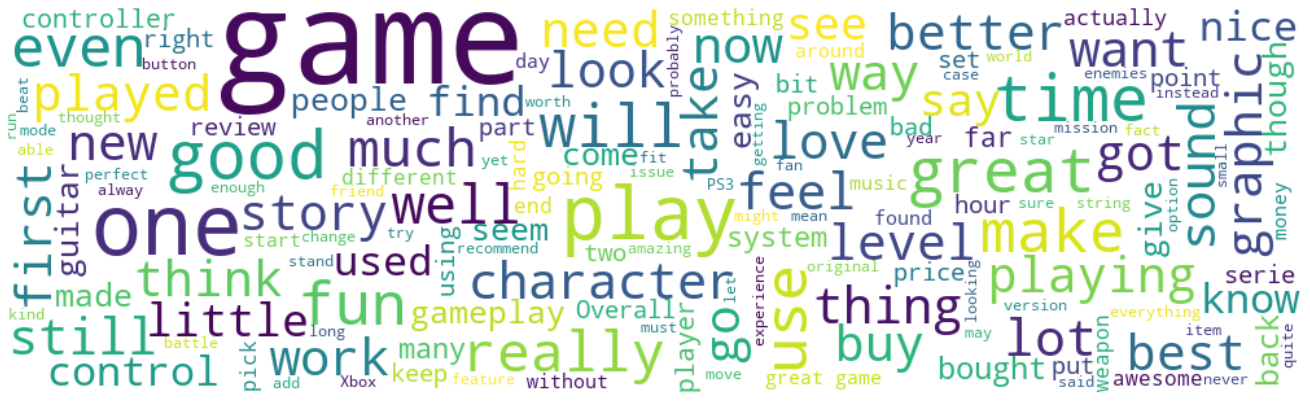

In [15]:
# Generate a word cloud to observe the most occurring words in the reviews
def wordcloud(clean_dataset):
    wordcloud = WordCloud(width = 1000, height = 300,
                          background_color ='white',
                          max_font_size = 100, 
                          min_font_size = 10).generate(" ".join(clean_dataset.values))                      
    plt.figure(figsize = (18, 6), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

# Apply the wordcloud funtion with clean_dataset['text']
wordcloud(clean_dataset['text'])

In [16]:
# Please ingore this line of coding, it was used to export the ‘exclusions_dataset_taskX.csv’ file only
"""
clean_dataset['excluded'] = pd.Series([0 for x in range(len(dataset.index))])
clean_dataset['reason_for_exclusion'] = pd.Series(['N/A' for x in range(len(dataset.index))])

frames = [clean_dataset, dataset]
result = pd.concat(frames)
result_dataset = result.drop_duplicates(subset=['review_id'])
result_dataset = result_dataset.drop(columns=['verified'])

from google.colab import files
result_dataset.to_csv('exclusions_dataset_task4.csv') 
files.download('exclusions_dataset_task4.csv')
"""

"\nclean_dataset['excluded'] = pd.Series([0 for x in range(len(dataset.index))])\nclean_dataset['reason_for_exclusion'] = pd.Series(['N/A' for x in range(len(dataset.index))])\n\nframes = [clean_dataset, dataset]\nresult = pd.concat(frames)\nresult_dataset = result.drop_duplicates(subset=['review_id'])\nresult_dataset = result_dataset.drop(columns=['verified'])\n\nfrom google.colab import files\nresult_dataset.to_csv('exclusions_dataset_task4.csv') \nfiles.download('exclusions_dataset_task4.csv')\n"

## **Text Pre-processing**

**1. Resolve the contractions in English**
I use the contractions package from https://github.com/kootenpv/contractions to resolve contractions and slang in English such as I've -> I have, etc. 

In [17]:
clean_dataset['processed_text'] = clean_dataset['text'].map(lambda docs:contractions.fix(docs))

**2. Convert into lowercase words and remove HTML tags, including URLs**

In [18]:
def text_processing(document):
    # Convert uppercase words into lowercase words
    document = str(document)
    document = document.lower()

    # Remove HTML tags using RegEx
    document = document.replace('{html}', '') 
    remove_tag = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    remove_tag_text = re.sub(remove_tag, '', document)

    # Remove URLs
    remove_url = re.sub(r'https?://\S+|www\.\S+', '', remove_tag_text)
    
    # Remove number
    remove_num = re.sub('[0-9]+', '', remove_url)
    
    return remove_num

clean_dataset['processed_text'] = clean_dataset['processed_text'].map(lambda docs:text_processing(docs))

**3. Tokenization**

In [19]:
clean_dataset['processed_text'] = clean_dataset['processed_text'].map(word_tokenize)

**4. Remove stopwords**

In [20]:
stopwords_set = set(stopwords.words('english'))
clean_dataset['processed_text'] = clean_dataset['processed_text'].apply(lambda docs: [word for word in docs if word not in stopwords_set])

**5. Part of speech (POS) of English words in order to improve spelling and accuracy**

In [21]:
# More detail at https://www.nltk.org/book/ch05.html
wordtags = {"N":wn.NOUN, "V":wn.VERB, "J":wn.ADJ, "R":wn.ADV}

# Combining taggers of N-Gram Tagging
brown_tagged_sents = brown.tagged_sents(categories = 'news')
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(brown_tagged_sents, backoff = t0)
t2 = nltk.BigramTagger(brown_tagged_sents, backoff = t1)

def pos_tagger(docs, pos_tag_type = "pos_tag"):
    tagger = t2.tag(docs)
    tagger = [(word, wordtags.get(pos_tag[0])) 
    if pos_tag[0] in wordtags.keys() 
    else (word, wn.NOUN) 
    for (word, pos_tag) in tagger]
    return tagger

clean_dataset['processed_text'] = clean_dataset['processed_text'].apply(lambda docs: pos_tagger(docs))

**6. Lemmatization**

In [22]:
def lemmatizer(docs):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(word, tag) for word, tag in docs]
    return lemmatized

clean_dataset['processed_text'] = clean_dataset['processed_text'].apply(lambda docs: lemmatizer(docs))

# Apply the removal of stopwords
clean_dataset['processed_text'] = clean_dataset['processed_text'].apply(lambda docs: [word for word in docs if word not in stopwords_set])

# Join words together
clean_dataset['processed_text'] = [' '.join(map(str, word)) for word in clean_dataset['processed_text']]

**7. Remove punctuation**

In [23]:
remove_punc = string.punctuation
def remove_punctuation(document):
    return document.translate(str.maketrans('', '', remove_punc))

clean_dataset['processed_text']=clean_dataset['processed_text'].apply(lambda docs: remove_punctuation(docs))

In [24]:
# Text after preprocessing
clean_dataset.head(10)

,review_id,text,review_score,product_category,processed_text
0,product_review_000000,I am one of those people who had Gran Turismo ...,1.0,video_games,one people gran turismo special addition h...
1,product_review_000001,This game is awful for several reasons.\n1. T...,1.0,video_games,game awful several reason control awful way...
2,product_review_000002,This case is great for travel with the 3Ds or ...,5.0,video_games,case great travel lite hold game extra stylu...
3,product_review_000003,My go-to mic cable for quite a few years now. ...,5.0,musical_instruments,goto mic cable quite year spiral shield easy ...
4,product_review_000004,The left one falls fairly frequently even when...,4.0,video_games,leave one fall fairly frequently even gameplay...
5,product_review_000005,I've played a lot of strings. These are what ...,5.0,musical_instruments,play lot string settle tone durability fee...
6,product_review_000006,Love these things.. Love Amazon,5.0,video_games,love thing love amazon
9,product_review_000009,"The reviews were so negative, I was scared to ...",5.0,video_games,review negative scared purchase game mac gam...
10,product_review_000010,Never played the game it was brought for a chi...,5.0,video_games,never play game bring child play leave feed ba...
11,product_review_000011,Hot Shots golf games has always been a fun cas...,5.0,video_games,hot shot golf game always fun casual take game...


**More Exploratory Data Analysis**

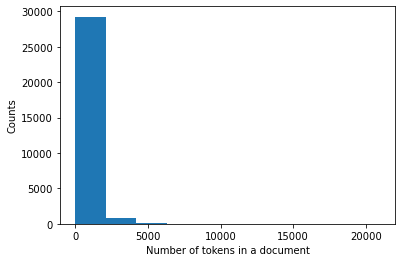

In [25]:
# Number of tokens in each document
processed = list((clean_dataset['processed_text']))
doc_tokens= []
for doc in processed:
  doc_tokens.append(len(doc))

# plot the distribution of lengths in an histogram
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(doc_tokens)
ax.set_xlabel('Number of tokens in a document')
_ =ax.set_ylabel('Counts')

5.0    18168
4.0     5833
3.0     2951
1.0     1754
2.0     1461
Name: review_score, dtype: int64


[]

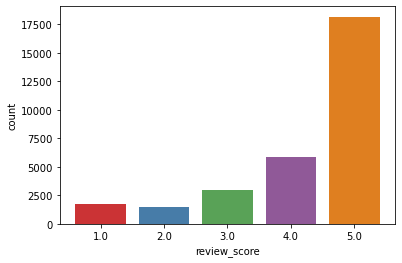

In [26]:
# Star Ratings
# Display total number
print(clean_dataset.review_score.value_counts())
sns.countplot(clean_dataset.review_score, palette = 'Set1')

# visualise the result
plt.plot()

video_games            20328
musical_instruments     9839
Name: product_category, dtype: int64


[]

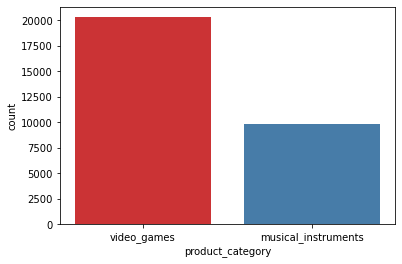

In [27]:
# Product categories
# Display total number
print(clean_dataset.product_category.value_counts())
sns.countplot(clean_dataset.product_category, palette = 'Set1')

# visualise the result
plt.plot()

[]

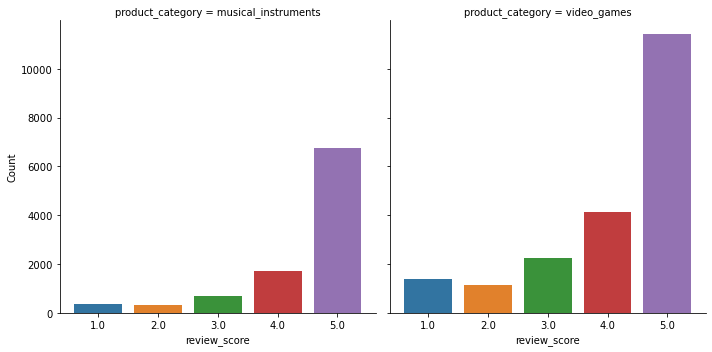

In [28]:
# Plot the relationship between Family Members and Response
df3 = clean_dataset.groupby(['review_score', 'product_category'])['review_id'].count().to_frame().rename(columns = {'review_id':'Count'}).reset_index()
graph3 = sns.catplot(x = 'review_score', y = 'Count', col = 'product_category',
                data = df3, kind = 'bar',
                height = 5, aspect = 1)

# visualise the result
plt.plot()

## **Task 2: Predict the categories (Video Games or Musical Instrument)**

### **Data Processing**

In [59]:
# 1: 'video_games', 0: 'musical_instruments'
le = LabelEncoder()
le.fit(clean_dataset['product_category'])

clean_dataset['label_encoded'] = le.transform(clean_dataset['product_category'])
clean_dataset['label_encoded'].head()

y2 = clean_dataset['label_encoded']

**Undersampling technique for imbalance dataset**

In [60]:
# For Experiment ONLY
"""
print(f'The original dataset shape : {Counter(y2)}')

rus = RandomUnderSampler(random_state= 0)
X2_resampled, y2_resampled = rus.fit_resample(X, y2)

print(f'The dataset shape after oversampling {Counter(y2_resampled)}')
"""

"\nprint(f'The original dataset shape : {Counter(y2)}')\n\nrus = RandomUnderSampler(random_state= 0)\nX2_resampled, y2_resampled = rus.fit_resample(X, y2)\n\nprint(f'The dataset shape after oversampling {Counter(y2_resampled)}')\n"

**Synthetic Minority Oversampling Technique (SMOTE) for imbalance dataset**

In [61]:
print(f'The original dataset shape : {Counter(y2)}')

smote = SMOTE(random_state=42)
X2_smote, y2_smote = smote.fit_resample(X, y2)

print(f'The dataset shape after oversampling {Counter(y2_smote)}')

The original dataset shape : Counter({1: 20328, 0: 9839})
The dataset shape after oversampling Counter({1: 20328, 0: 20328})


In [62]:
# Split the dataste
x2_train, x2_test, y2_train, y2_test = train_test_split(X2_smote, y2_smote, test_size = 0.2, stratify = y2_smote, random_state = 42)

# Split the validation dataset
X2_train, X2_valid, Y2_train, Y2_valid = train_test_split(x2_train, y2_train, test_size = 0.1, stratify = y2_train, random_state = 42)

In [63]:
x2_train.shape, x2_test.shape

((32524, 7884), (8132, 7884))

### **Modelling**

**Model 1: Random Forest**

In [64]:
# Random Forest
rf = RandomForestClassifier(n_estimators = 50, 
                            max_depth = 5, 
                            random_state = 42)

# Fit the model
rf.fit(x2_train,y2_train)

# Prediction
rf_predict = rf.predict(x2_test)

**Model 2: Random Forest Hyperparameter Tuning with Grid Search Cross Validation**

In [65]:
#  K-fold Cross Validation
rf_kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)

randomf = RandomForestClassifier()

param_grid = {'max_depth': [10, 50],
              'min_samples_leaf': [1, 3],
              'min_samples_split': [10, 12],
              'n_estimators': [10, 50, 100]}

grid_search_rf = GridSearchCV(estimator = randomf, 
                              param_grid = param_grid, 
                              cv = rf_kfold, 
                              n_jobs = -1, 
                              verbose = 2)

In [66]:
grid_search_rf.fit(x2_train, y2_train)
print('The best parameters of the Random Forest model after tuning Hyperparameters')
grid_search_rf.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  11.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=12, n_estimators=10; total time=   2.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=12, n_estimators=10; total time=   2.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  10.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  19.4s
[CV] END max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=10; total time=   2.3s
[CV] END max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=10; total time=   2.2s
The best parameters of the Random Forest model after tuning Hyperparameters


{'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [67]:
# Prediction using the best parameters
best_params_rf = grid_search_rf.best_estimator_
y_pred_rf = best_params_rf.predict(x2_test)

**Model 3: CatBoost**

In [68]:
# CatBoost
cat = CatBoostClassifier(n_estimators = 10, 
                         learning_rate = 0.1)

# Fit the model
cat.fit(x2_train, y2_train)

# Prediction
cat_predict = cat.predict(x2_test)

0:	learn: 0.5775360	total: 562ms	remaining: 5.06s
1:	learn: 0.4857896	total: 866ms	remaining: 3.46s
2:	learn: 0.4289216	total: 1.15s	remaining: 2.67s
3:	learn: 0.3842071	total: 1.51s	remaining: 2.27s
4:	learn: 0.3562504	total: 1.78s	remaining: 1.78s
5:	learn: 0.3311401	total: 2.08s	remaining: 1.39s
6:	learn: 0.3198474	total: 2.34s	remaining: 1s
7:	learn: 0.3013121	total: 2.59s	remaining: 649ms
8:	learn: 0.2918117	total: 2.88s	remaining: 320ms
9:	learn: 0.2849821	total: 3.14s	remaining: 0us


**Model 4: CatBoost Hyperparameter Tuning with Grid Search Cross Validation**

In [69]:
#  K-fold Cross Validation
cat_kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)

catb = CatBoostClassifier()

param_grid = {'max_depth': [5, 10],
              'n_estimators':[10, 100],
              'learning_rate': [0.01, 0.1]}

grid_search_cat = GridSearchCV(estimator = catb, 
                              param_grid = param_grid, 
                              cv = cat_kfold)

In [70]:
grid_search_cat.fit(x2_train, y2_train)
print('The best parameters of the CatBoost model after tuning Hyperparameters')
grid_search_cat.best_params_

0:	learn: 0.6808614	total: 214ms	remaining: 1.92s
1:	learn: 0.6673003	total: 382ms	remaining: 1.53s
2:	learn: 0.6550459	total: 637ms	remaining: 1.49s
3:	learn: 0.6426435	total: 809ms	remaining: 1.21s
4:	learn: 0.6317348	total: 989ms	remaining: 989ms
5:	learn: 0.6209447	total: 1.22s	remaining: 814ms
6:	learn: 0.6101984	total: 1.42s	remaining: 608ms
7:	learn: 0.5993571	total: 1.61s	remaining: 403ms
8:	learn: 0.5888457	total: 1.8s	remaining: 201ms
9:	learn: 0.5787470	total: 2s	remaining: 0us
0:	learn: 0.6793303	total: 232ms	remaining: 2.09s
1:	learn: 0.6648362	total: 449ms	remaining: 1.79s
2:	learn: 0.6515241	total: 619ms	remaining: 1.44s
3:	learn: 0.6391210	total: 797ms	remaining: 1.2s
4:	learn: 0.6272151	total: 1.01s	remaining: 1.01s
5:	learn: 0.6167451	total: 1.21s	remaining: 807ms
6:	learn: 0.6052389	total: 1.41s	remaining: 606ms
7:	learn: 0.5950031	total: 1.59s	remaining: 397ms
8:	learn: 0.5859542	total: 1.77s	remaining: 196ms
9:	learn: 0.5755541	total: 1.94s	remaining: 0us
0:	learn:

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}

In [71]:
# Prediction
best_params_cat = grid_search_cat.best_estimator_
y_pred_cat = best_params_cat.predict(x2_test)

### **Model Evaluation**

**Model 1 Evaluation: Random Forest**

In [72]:
# Accuracy score
acc_score_rf = round(accuracy_score(y2_test, rf_predict) * 100, 5)
print(f'Accuracy score for the Random Forest model: {acc_score_rf}%\n')

# Classification report
print(classification_report(y2_test, rf_predict))

Accuracy score for the Random Forest model: 87.85047%

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      4066
           1       0.99      0.77      0.86      4066

    accuracy                           0.88      8132
   macro avg       0.90      0.88      0.88      8132
weighted avg       0.90      0.88      0.88      8132



In [73]:
# ROC curve and AUC score
rf_auc = roc_auc_score(y2_test, rf.predict_proba(x2_test)[:,1])
print('The AUC score of Random Forest model:')
rf_auc

The AUC score of Random Forest model:


0.9610880627056422

In [74]:
# Confusion matrix of the Random Forest model
confusion_matrix(y2_test, rf_predict)

array([[4020,   46],
       [ 942, 3124]])

**Model 2 Evaluation: Random Forest model after tuning hyperparameters**

In [75]:
# Accuracy score after tuning hyperparameters
acc_score_hy_rf = round(accuracy_score(y2_test, y_pred_rf) * 100, 5)
print(f'Accuracy score for the Random Forest model after tuning hyperparamters: {acc_score_hy_rf}%')

# Classification report
print(classification_report(y2_test, y_pred_rf))

Accuracy score for the Random Forest model after tuning hyperparamters: 92.28972%
              precision    recall  f1-score   support

           0       0.88      0.97      0.93      4066
           1       0.97      0.87      0.92      4066

    accuracy                           0.92      8132
   macro avg       0.93      0.92      0.92      8132
weighted avg       0.93      0.92      0.92      8132



In [80]:
# ROC curve and AUC score
hy_rf_auc = roc_auc_score(y2_test, grid_search_rf.predict_proba(x2_test)[:,1])
print('The AUC score of Random Forest model after tuning hyperparamters:')
hy_rf_auc

The AUC score of Random Forest model after tuning hyperparamters:


0.9842740804758862

In [77]:
# Confusion matrix of the Random Forest model
confusion_matrix(y2_test, y_pred_rf)

array([[3963,  103],
       [ 524, 3542]])

**Model 3 Evaluation: CatBoost**

In [78]:
# Accuracy score
acc_score_cat = round(accuracy_score(y2_test, cat_predict) * 100, 5)
print(f'Accuracy score for the CatBoost model: {acc_score_cat}%\n')

# Classification report
print(classification_report(y2_test, cat_predict))

Accuracy score for the CatBoost model: 88.37924%

              precision    recall  f1-score   support

           0       0.81      0.99      0.90      4066
           1       0.99      0.77      0.87      4066

    accuracy                           0.88      8132
   macro avg       0.90      0.88      0.88      8132
weighted avg       0.90      0.88      0.88      8132



In [83]:
# ROC curve and AUC score
cat_auc = roc_auc_score(y2_test, cat.predict_proba(x2_test)[:,1])
print('The AUC score of CatBoost model:')
cat_auc

The AUC score of CatBoost model:


0.9664017639107215

In [82]:
# Confusion matrix of the CatBoost model
confusion_matrix(y2_test, cat_predict)

array([[4041,   25],
       [ 920, 3146]])

**Model 4 Evaluation: CatBoost model after tuning hyperparameters**


In [84]:
# Accuracy score after tuning hyperparameters
acc_score_hy_cat = round(accuracy_score(y2_test, y_pred_cat) * 100, 5)
print(f'Accuracy score for the CatBoost model after tuning hyperparamters: {acc_score_hy_cat}%')

# Classification report
print(classification_report(y2_test, y_pred_cat))

Accuracy score for the CatBoost model after tuning hyperparamters: 92.92917%
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      4066
           1       0.97      0.88      0.93      4066

    accuracy                           0.93      8132
   macro avg       0.93      0.93      0.93      8132
weighted avg       0.93      0.93      0.93      8132



In [85]:
# ROC curve and AUC score
hy_cat_auc = roc_auc_score(y2_test, grid_search_cat.predict_proba(x2_test)[:,1])
print('The AUC score of CatBoost model after tuning hyperparamters:')
hy_cat_auc

The AUC score of CatBoost model after tuning hyperparamters:


0.9861565707876119

In [86]:
# Confusion matrix of the CatBoost model
confusion_matrix(y2_test, y_pred_cat)


array([[3963,  103],
       [ 472, 3594]])

**The comparison of accuracy scores**

[]

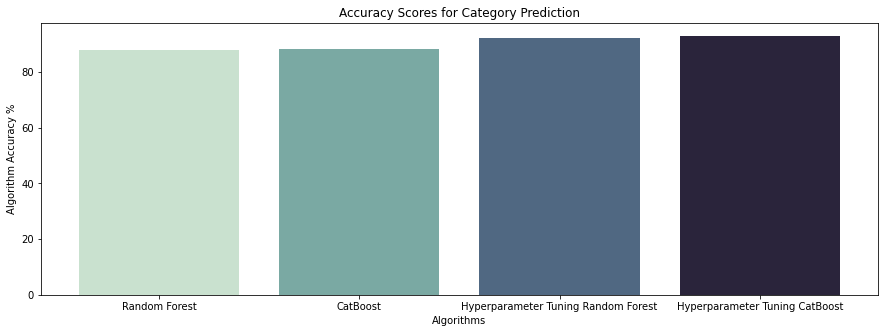

In [87]:
plt.style.use('seaborn-pastel')

x = ['Random Forest',
     'CatBoost',
     'Hyperparameter Tuning Random Forest',
     'Hyperparameter Tuning CatBoost'
     ]

y = [acc_score_rf,
     acc_score_cat,
     acc_score_hy_rf,
     acc_score_hy_cat,
     ]

fig, ax = plt.subplots(figsize =(15,5))
sns.barplot(x = x, y = y, palette = 'ch:start=.3,rot=-.5')
plt.xlabel('Algorithms')
plt.ylabel('Algorithm Accuracy %')
plt.title('Accuracy Scores for Category Prediction')

# save the file
#plt.savefig('/Users/golf/Documents/University of Greenwich/Term 2 - COMP1804 Applied Machine Learning/COMP1804 Coursework/Category Accuracy', dpi=300, bbox_inches = 'tight')

#visualise the result
plt.plot()

In [88]:
# Visualise the accuracy score by table

results_df = pd.DataFrame(data=[[x[0], y[0]],
                                [x[1], y[1]],
                                [x[2], y[2]],
                                [x[3], y[3]]
                               ], 
                          columns=['Model', 'Algorithms Accuracy %'])

results_df

,Model,Algorithms Accuracy %
0,Random Forest,87.85047
1,CatBoost,88.37924
2,Hyperparameter Tuning Random Forest,92.28972
3,Hyperparameter Tuning CatBoost,92.92917


**The comparison of Confusion Matrices**

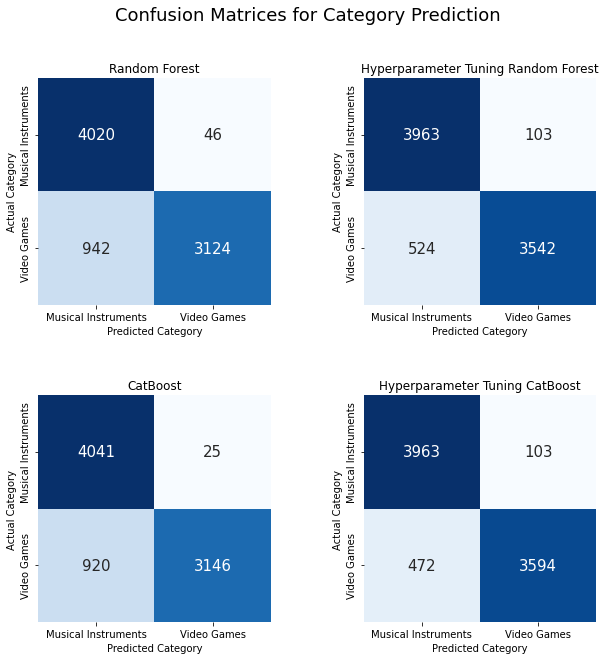

In [90]:
# Calculate the confusion matrix
cm_rf = confusion_matrix(y2_test, rf_predict)
cm_hy_rf = confusion_matrix(y2_test, y_pred_rf)
cm_cat = confusion_matrix(y2_test, cat_predict)
cm_hy_cat = confusion_matrix(y2_test, y_pred_cat)

# Visualise the result on the screen

plt.figure(figsize=(10,10))

plt.suptitle('Confusion Matrices for Category Prediction', fontsize = 18)
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)

plt.subplot(2,2,1)
plt.title('Random Forest')
cm_rf_df = pd.DataFrame(cm_rf,
                        index = ['Musical Instruments','Video Games'], 
                        columns = ['Musical Instruments','Video Games'])
sns.heatmap(cm_rf_df, annot = True, cmap = 'Blues', fmt = 'd', cbar=False, annot_kws = {'size': 15})
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')

plt.subplot(2,2,2)
plt.title('Hyperparameter Tuning Random Forest')
cm_hy_rf_df = pd.DataFrame(cm_hy_rf,
                        index = ['Musical Instruments','Video Games'], 
                        columns = ['Musical Instruments','Video Games'])
sns.heatmap(cm_hy_rf_df, annot = True, cmap = 'Blues', fmt = 'd', cbar=False, annot_kws = {'size': 15})
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')

plt.subplot(2,2,3)
plt.title('CatBoost')
cm_cat_df = pd.DataFrame(cm_cat,
                        index = ['Musical Instruments','Video Games'], 
                        columns = ['Musical Instruments','Video Games'])
sns.heatmap(cm_cat_df, annot = True, cmap = 'Blues', fmt = 'd', cbar = False, annot_kws = {'size': 15})
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')

plt.subplot(2,2,4)
plt.title('Hyperparameter Tuning CatBoost')
cm_hy_cat_df = pd.DataFrame(cm_hy_cat,
                        index = ['Musical Instruments','Video Games'], 
                        columns = ['Musical Instruments','Video Games'])
sns.heatmap(cm_hy_cat_df, annot = True, cmap = 'Blues', fmt = 'd', cbar = False, annot_kws = {'size': 15})
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
# save the file
plt.savefig('/Users/golf/Documents/University of Greenwich/Term 2 - COMP1804 Applied Machine Learning/COMP1804 Coursework/Category Confusion Matrices', dpi=300, bbox_inches = 'tight')

# visualise the result
plt.show()

**The comparison of ROC Curve and AUC score for each model**

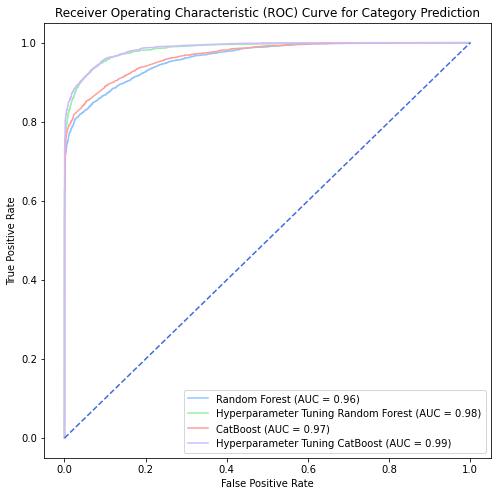

In [92]:
# Set the figure size
plt.figure(figsize=(8,8))

models = [
{
    'algorithm': 'Random Forest',
    'model': rf,
},
{
    'algorithm': 'Hyperparameter Tuning Random Forest',
    'model': grid_search_rf,
},
{
    'algorithm': 'CatBoost',
    'model': cat,
},
{
    'algorithm': 'Hyperparameter Tuning CatBoost',
    'model': grid_search_cat,
}
]

# Visualise the plot
for m in models:
    model = m['model']
    false_positive_rate,true_positive_rate, thresholds = roc_curve(y2_test, model.predict_proba(x2_test)[:,1])
    roc_auc = roc_auc_score(y2_test, model.predict_proba(x2_test)[:,1])
    plt.plot(false_positive_rate, true_positive_rate,label = '%s (AUC = %0.2f)' % (m['algorithm'], roc_auc))

# Set the plot and create reference line
plt.plot((0,1), ls='dashed', color = 'royalblue')
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')    
plt.title('Receiver Operating Characteristic (ROC) Curve for Category Prediction')

# save the file
plt.savefig('/Users/golf/Documents/University of Greenwich/Term 2 - COMP1804 Applied Machine Learning/COMP1804 Coursework/Category ROC curve', dpi=300, bbox_inches = 'tight')

# visualise the result
plt.show()

**Plot learning curves**

In [94]:
# Adapted code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = -1, train_sizes = np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

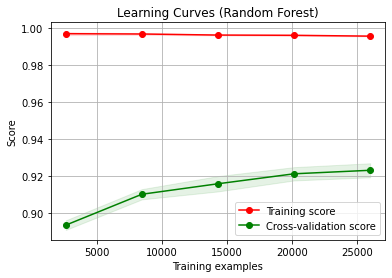

In [95]:
# Random Forest model
g = plot_learning_curve(best_params_rf,"Learning Curves (Random Forest)", x2_train, y2_train, cv = rf_kfold)

0:	learn: 0.5716654	total: 12.9s	remaining: 21m 15s
1:	learn: 0.4829276	total: 26.6s	remaining: 21m 45s
2:	learn: 0.4268928	total: 40.3s	remaining: 21m 44s
3:	learn: 0.3831324	total: 54s	remaining: 21m 35s
4:	learn: 0.3511728	total: 1m 6s	remaining: 21m 11s
5:	learn: 0.3262537	total: 1m 20s	remaining: 20m 59s
6:	learn: 0.3091037	total: 1m 33s	remaining: 20m 38s
7:	learn: 0.2893430	total: 1m 46s	remaining: 20m 27s
8:	learn: 0.2787278	total: 2m	remaining: 20m 15s
9:	learn: 0.2702229	total: 2m 13s	remaining: 20m
10:	learn: 0.2626803	total: 2m 26s	remaining: 19m 45s
11:	learn: 0.2559431	total: 2m 39s	remaining: 19m 28s
12:	learn: 0.2479842	total: 2m 52s	remaining: 19m 11s
13:	learn: 0.2412290	total: 3m 5s	remaining: 18m 56s
14:	learn: 0.2369419	total: 3m 17s	remaining: 18m 40s
15:	learn: 0.2322341	total: 3m 31s	remaining: 18m 28s
16:	learn: 0.2276663	total: 3m 44s	remaining: 18m 14s
17:	learn: 0.2242168	total: 3m 56s	remaining: 17m 59s
18:	learn: 0.2218156	total: 4m 10s	remaining: 17m 47s


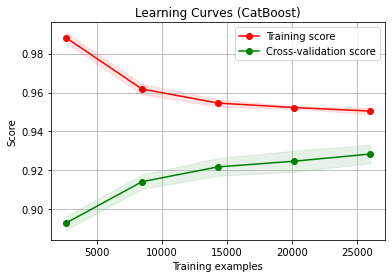

In [96]:
# CatBoost model
g = plot_learning_curve(best_params_cat,"Learning Curves (CatBoost)", x2_train, y2_train, cv = cat_kfold)

**Predicted examples from the test dataset**

In [97]:
# 0: 'musical_instruments', 1: 'video_games'

# Model 1: Random Forest
rf_examples = rf_predict[0:10]
rf_converted_0 = np.where(rf_examples == 0, 'musical_instruments', rf_examples)
rf_converter = np.where(rf_examples == 1, 'video_games', rf_converted_0)
print('The predicted examples from the test dataset of the Random Forest model')
print(rf_converter)
print('The numerical prediction', rf_predict[0:10])

# Model 2: Hyperparameters Tuning Random Forest     
hy_rf_examples = y_pred_rf[0:10]
hy_rf_converted_0 = np.where(hy_rf_examples == 0, 'musical_instruments', hy_rf_examples)
hy_rf_converter = np.where(hy_rf_examples == 1, 'video_games', hy_rf_converted_0)
print('\nThe predicted examples from the test dataset of the Random Forest model after tuning hyperparameters')
print(hy_rf_converter)
print('The numerical prediction', hy_rf_examples)

# Model 3: CatBoost
cat_examples = cat_predict[0:10]
cat_converted_0 = np.where(cat_examples == 0, 'musical_instruments', cat_examples)
cat_converter = np.where(cat_examples == 1, 'video_games', cat_converted_0)
print('\nThe predicted examples from the test dataset of the CatBoost model')
print(cat_converter)
print('The numerical prediction', cat_examples)

# Model 4: Hyperparameters Tuning CatBoost    
hy_cat_examples = y_pred_cat[0:10]
hy_cat_converted_0 = np.where(hy_cat_examples == 0, 'musical_instruments', hy_cat_examples)
hy_cat_converter = np.where(hy_cat_examples == 1, 'video_games', hy_rf_converted_0)
print('\nThe predicted examples from the test dataset of the CatBoost model after tuning hyperparameters')
print(hy_cat_converter)
print('The numerical prediction', hy_cat_examples)

The predicted examples from the test dataset of the Random Forest model
['musical_instruments' 'musical_instruments' 'video_games'
 'musical_instruments' 'musical_instruments' 'musical_instruments'
 'video_games' 'musical_instruments' 'video_games' 'musical_instruments']
The numerical prediction [0 0 1 0 0 0 1 0 1 0]

The predicted examples from the test dataset of the Random Forest model after tuning hyperparameters
['musical_instruments' 'video_games' 'video_games' 'musical_instruments'
 'musical_instruments' 'musical_instruments' 'video_games'
 'musical_instruments' 'video_games' 'musical_instruments']
The numerical prediction [0 1 1 0 0 0 1 0 1 0]

The predicted examples from the test dataset of the CatBoost model
['musical_instruments' 'musical_instruments' 'video_games'
 'musical_instruments' 'musical_instruments' 'musical_instruments'
 'video_games' 'musical_instruments' 'video_games' 'musical_instruments']
The numerical prediction [0 0 1 0 0 0 1 0 1 0]

The predicted examples f